The goal of this notebook is to evaluate the embeddings that we have created. Specifically, we are interested in how well (both qualitative and quantitatively) our embeddings do at matching questions with context in the statement portion of the earnings call transcript. Since we divided the statements portion of each earnings call transcript into chunks of size at most 64 words, this reduces to matching each question with the statement chunk that is most "similar" in terms of some predefined similarity metric (e.g. cosine similarity).

In [165]:
import numpy as np
import pickle
import matplotlib.pyplot as plt

In [173]:
# Change this to point to your embeddings
FILE_PATH = 'embeddings/bert_embeddings.pickle'

In [174]:
with open(FILE_PATH, 'rb') as f:
    transcript_embeddings = pickle.load(f)

In [175]:
def cosine_sim(u, v, sparse=False):
    if sparse:
        u = u.toarray().T
        v = v.toarray().T
    u = np.reshape(u, (u.shape[0],))
    v = np.reshape(v, (v.shape[0],))
    return np.dot(u.T, v) / (np.linalg.norm(u) * np.linalg.norm(v))

In [176]:
def jaccard_sim(u, v, sparse=False):
    if sparse:
        u = u.toarray().T
        v = v.toarray().T
    return np.sum(np.minimum(u, v)) / np.sum((u + v))

In [177]:
# Define this as you see fit
sim_func = cosine_sim

In [178]:
NUM_SAMPLES = len(transcript_embeddings)

In [180]:
q_to_chunk = []
scores = []
for i in range(NUM_SAMPLES):
    curr = {}
    for q_a_idx in range(len(transcript_embeddings[i][1])):
        if transcript_embeddings[i][1][q_a_idx][1] == 1: continue  # This is an answer
        q_embedding = transcript_embeddings[i][1][q_a_idx][0]
        
        curr_best_score, curr_best_chunk = None, None
        for chunk_idx in range(len(transcript_embeddings[i][0])):
            chunk_embedding = transcript_embeddings[i][0][chunk_idx]
            score = sim_func(q_embedding, chunk_embedding)
            
            if curr_best_score is None or score > curr_best_score:
                curr_best_score = score
                curr_best_chunk = chunk_idx
        scores.append(curr_best_score)
        curr[q_a_idx] = curr_best_chunk
    q_to_chunk.append(curr)

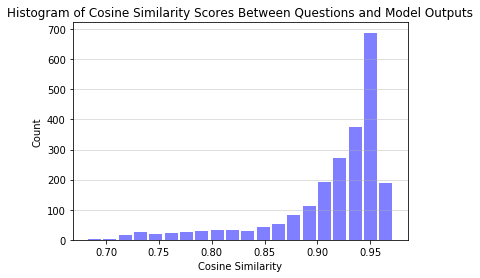

In [181]:
num_bins = 20
n, bins, patches = plt.hist(scores, num_bins, facecolor='blue', alpha=0.5, rwidth=0.85)
plt.grid(axis='y', alpha=0.5)
plt.xlabel('Cosine Similarity')
plt.ylabel('Count') # Adjust if using Jaccard Similarity
plt.title(r'Histogram of Cosine Similarity Scores Between Questions and Model Outputs')
plt.show()

In [182]:
# Now we load the original transcripts (only using the training data for now)
with open('data/transcripts_train.pickle', 'rb') as f:
    transcripts = pickle.load(f)

In [185]:
for i, mapping in enumerate(q_to_chunk):
    for q_idx in mapping.keys():
        print ("QUESTION TEXT:\n")
        print(transcripts[i][3][q_idx][0])
        print("\nANSWER TEXT\n")
        print(transcripts[i][3][q_idx + 1][0])
        print("\nMODEL OUTPUT:\n")
        print(transcripts[i][2][mapping[q_idx]] + '\n')
        print('#' * 75)

QUESTION TEXT:

operator instructions first question comes line bruce geller dghm please proceed hi good morning guys

ANSWER TEXT

hi bruce

MODEL OUTPUT:

thank operator good morning thank joining us conference call fourth fiscal quarter full year ended october 1 2016 call today michael weinstein chairman ceo vinny pascal chief operating officer yet obtained copy press release issued newswire yesterday available website review full text press release along associated financial tables please go homepage begin however like read safe harbor statement need remind everyone part discussion afternoon

###########################################################################
QUESTION TEXT:

good thanks glad hear things turned around far current quarter 7 negative comp related 13 weeks versus 14 weeks

ANSWER TEXT

yes includes additional week last year looking comparing 14 weeks 13 weeks year dismal might imply comp could come something like 2 probably somewhere along line 2 3

MODEL OUTPU

IndexError: list index out of range